# Betting markets - chart election winner at sportsbet

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Convert-odds-to-probabilities" data-toc-modified-id="Convert-odds-to-probabilities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convert odds to probabilities</a></span></li><li><span><a href="#Plot-probabilities" data-toc-modified-id="Plot-probabilities-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot probabilities</a></span><ul class="toc-item"><li><span><a href="#Type-of-Parliament" data-toc-modified-id="Type-of-Parliament-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Type of Parliament</a></span></li><li><span><a href="#Election-winner" data-toc-modified-id="Election-winner-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Election winner</a></span></li></ul></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

import common

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

## Get data

In [2]:
# type of parliament
FILE = '../historical-data/sportsbet-2022-type-of-parliament.csv'
top = pd.read_csv(FILE, na_values = '-', parse_dates=['datetime'])
top = top.pivot(index='datetime', columns='variable', values='value').sort_index(ascending=True)
del top['Any Other'] # ignore longshot bias

In [3]:
# Fix up column names
names = {
    'Liberal/National Coalition Majority': 'Coalition Majority',
    'Liberal/National Coalition Minority': 'Coalition Minority',
}
order = ['Labor Majority', 'Labor Minority', 'Coalition Minority', 'Coalition Majority',]
top = top.rename(columns=names)[order]
top.tail()

variable,Labor Majority,Labor Minority,Coalition Minority,Coalition Majority
datetime,,,,
2022-02-22 11:45:44.389711,1.8,4.75,4.1,4.00
2022-02-23 11:45:44.204448,1.8,4.75,4.1,4.00
2022-02-24 11:45:44.807814,1.8,4.75,4.1,4.00
2022-02-25 11:45:44.050033,1.9,4.75,4.0,3.75
2022-02-26 11:45:48.440170,1.9,4.75,4.0,3.75


In [4]:
# election winner
FILE = '../historical-data/sportsbet-2022-election-winner.csv'
ew = pd.read_csv(FILE, na_values = '-', parse_dates=['datetime'])
ew = ew.pivot(index='datetime', columns='variable', values='value').sort_index(ascending=True)
del ew['Any Other'] # ignore longshot bias
ew.tail()

variable,Coalition,Labor
datetime,,
2022-02-22 12:15:45.271853,2.95,1.38
2022-02-23 12:15:44.453833,2.95,1.38
2022-02-24 12:15:44.099623,2.95,1.38
2022-02-25 12:15:45.779203,2.85,1.38
2022-02-26 12:15:42.485455,2.85,1.38


## Convert odds to probabilities

In [5]:
def convert(odds: pd.DataFrame) -> pd.DataFrame:
    
    # get raw probabilities
    raw_probs = 1 / odds
    
    # remove the bookmakers overround
    total = raw_probs.sum(axis=1)
    adj_probs = raw_probs.div(total, axis=0)
    
    return adj_probs

In [6]:
probs_top = convert(top)
probs_top.tail()

variable,Labor Majority,Labor Minority,Coalition Minority,Coalition Majority
datetime,,,,
2022-02-22 11:45:44.389711,0.440923,0.167086,0.193576,0.198415
2022-02-23 11:45:44.204448,0.440923,0.167086,0.193576,0.198415
2022-02-24 11:45:44.807814,0.440923,0.167086,0.193576,0.198415
2022-02-25 11:45:44.050033,0.419874,0.167950,0.199440,0.212736
2022-02-26 11:45:48.440170,0.419874,0.167950,0.199440,0.212736


In [7]:
probs_ew = convert(ew)
probs_ew.tail()

variable,Coalition,Labor
datetime,,
2022-02-22 12:15:45.271853,0.318707,0.681293
2022-02-23 12:15:44.453833,0.318707,0.681293
2022-02-24 12:15:44.099623,0.318707,0.681293
2022-02-25 12:15:45.779203,0.326241,0.673759
2022-02-26 12:15:42.485455,0.326241,0.673759


## Plot probabilities

### Type of Parliament

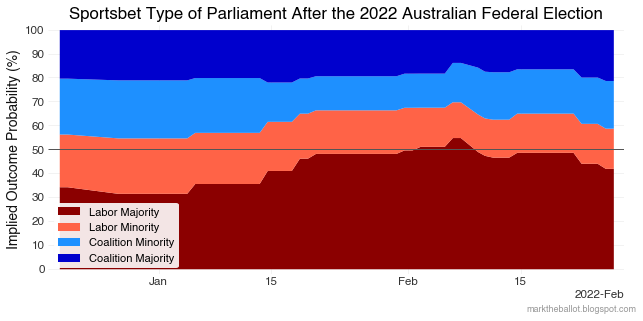

In [8]:
probs_top_pc = probs_top * 100
fig, ax = common.initiate_plot()

colors = ['darkred', 'tomato', 'dodgerblue', 'mediumblue']

from_ = np.repeat(0, len(probs_top_pc))
for i, column in enumerate(probs_top_pc.columns):
    to_ = from_ + probs_top_pc[column]
    ax.fill_between(probs_top_pc.index, from_, to_, label=column, color=colors[i])
    from_ = to_
ax.legend(loc='lower left', framealpha=0.9, prop={'size':11})
ax.axhline(50, lw=1, c='#555555')
ax.yaxis.set_major_locator(MaxNLocator(11)) 
title = f'Sportsbet Type of Parliament After the 2022 Australian Federal Election'
common.plot_finalise(ax, title=title, ylabel='Implied Outcome Probability (%)')

In [9]:
win_prob = pd.DataFrame([probs_top['Labor Majority'] + probs_top['Labor Minority'], 
                         probs_top['Coalition Minority'] + probs_top['Coalition Majority']],
                        index=['Labor', 'Coalition']).T



In [10]:
def chart_labor(probs, **kwargs):
    fig, ax = common.initiate_plot()
    ax.plot(probs.index, probs['Labor'] * 100, lw=2.5, color='darkred')
    common.plot_finalise(ax, ylabel='Implied Probability (%)', **kwargs)

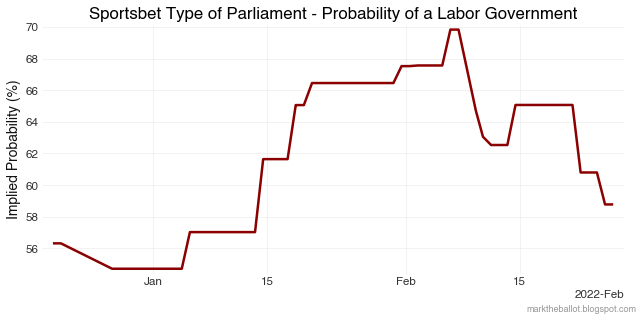

In [11]:
chart_labor(win_prob, title='Sportsbet Type of Parliament - Probability of a Labor Government')

### Election winner

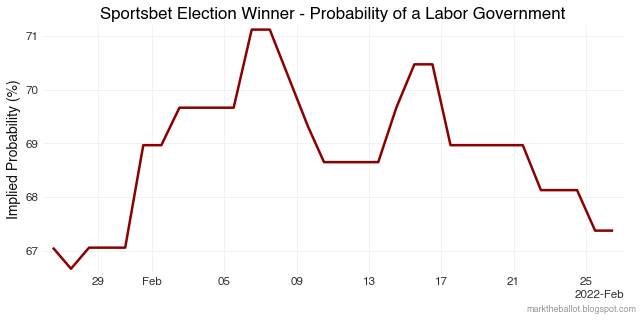

In [12]:
chart_labor(probs_ew, title='Sportsbet Election Winner - Probability of a Labor Government')